In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import time
from google.cloud import storage

#preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
#model
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [44]:
!ls

20231010_D&I_FRA_webvisitor-eda.ipynb
20231010_D&I_FRA_webvisitor-forecasting-modelling.ipynb


In [45]:
filename = "../website-visitor_20231020.csv"
df = pd.read_csv(filename)
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')
df = df.rename(columns={'event_date': 'date', 'f0_': 'count'}, inplace=False)
df

,date,count
0,2023-06-26,527
1,2023-06-27,485
2,2023-06-28,404
3,2023-06-29,328
4,2023-06-30,344
...,...,...
111,2023-10-15,309
112,2023-10-16,566
113,2023-10-17,535
114,2023-10-18,620


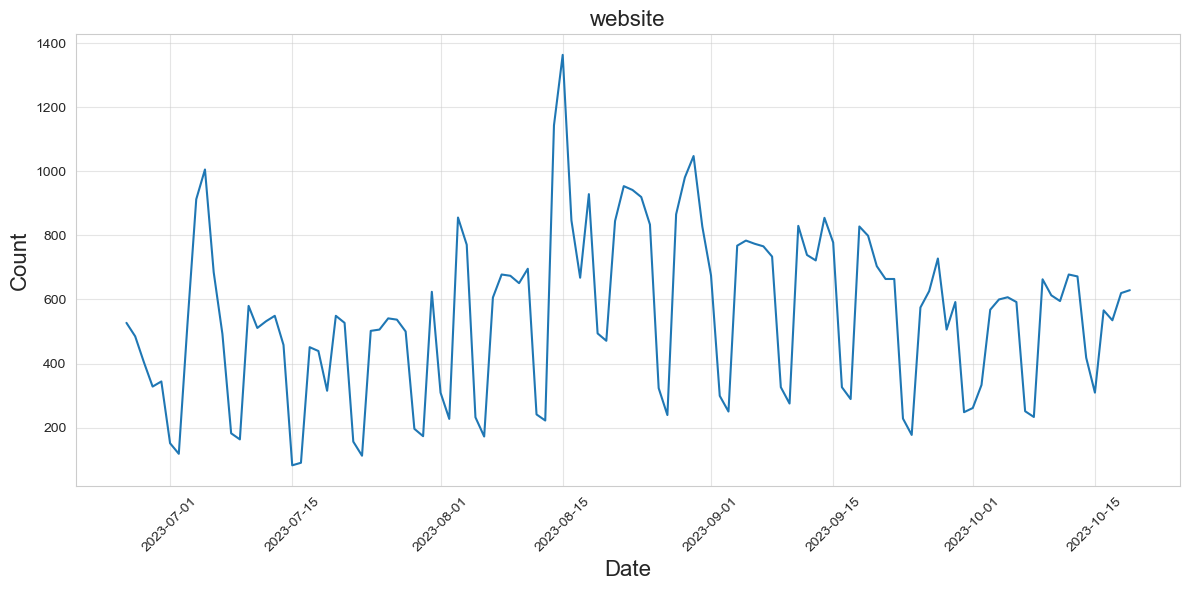

In [46]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=df, x='date', y='count')

# Customize the plot
plt.title('website', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [17]:
# Function to create lagged features for time series data
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Lag_{i}'] = data['count'].shift(i)
    return lagged_data

def data_process_stats(df, train_index, test_index):
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    return train_data, test_data

def data_process_ml(df, train_index, test_index):
    
    df = df.set_index('date', inplace=False)

    lag = 7  # Number of lagged values, adjust as needed
    # Apply the function to create lagged features
    lagged_df = create_lagged_features(df, lag)
    
    X = lagged_df.drop(['count'], axis=1)
    y = lagged_df['count']
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    
    return X_train, y_train, X_test, y_test, lagged_df
    
def data_process_prophet(df, train_index, test_index):
    df = df.rename(columns={'date': 'ds', 'count': 'y'}, inplace=False)
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    return train_data, test_data

# Model model
def model_exponential_smoothing(train_data, test_data):
    model = ExponentialSmoothing(train_data, seasonal="add", seasonal_periods=7)
    fit = model.fit()
    y_pred = fit.forecast(steps=len(test_data)) 
    return y_pred

def model_auto_arima(train_data, test_data):
    auto_model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = auto_model.predict(n_forecast, return_conf_int=True)
    return y_pred

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_lgb(X_train, y_train, X_test):
    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_xgboost(X_train, y_train, X_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def model_prophet(train_data_pr, test_data_pr):
    model = Prophet()
    model.fit(train_data_pr)
    y_pred = model.predict(test_data_pr)
    return y_pred['yhat']

def produce_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return [mae, rmse, mape]


In [18]:
n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize a list to store the mean squared errors for each fold
scores_es = []
scores_arima = []
scores_lr = []
scores_lgb = []
scores_xgb = []
scores_pr = []

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    #stats model
    train_data, test_data = data_process_stats(df, train_index, test_index)
    y_pred_es = model_exponential_smoothing(train_data, test_data)
    
    if i > 1: #auto ARIMA can't fit with small data
        y_pred_arima = model_auto_arima(train_data, test_data)
        metrics_arima = produce_metrics(y_test, y_pred_arima)
        scores_arima.append(metrics_arima)
    
    #ML model
    X_train, y_train, X_test, y_test, lagged_df = data_process_ml(df, train_index, test_index)
    y_pred_lr = model_linear_regression(X_train, y_train, X_test)
    y_pred_lgb = model_lgb(X_train, y_train, X_test)
    y_pred_xgb = model_xgboost(X_train, y_train, X_test)
    
    #Prophet model
    train_data_pr, test_data_pr = data_process_prophet(df, train_index, test_index)
    y_pred_pr = model_prophet(train_data_pr, test_data_pr)
    
    # Calculate the Mean Squared Error (MSE) for this fold
    metrics_es = produce_metrics(y_test, y_pred_es)
    metrics_lr = produce_metrics(y_test, y_pred_lr)
    metrics_lgb = produce_metrics(y_test, y_pred_lgb)
    metrics_xgb = produce_metrics(y_test, y_pred_xgb)
    metrics_pr = produce_metrics(y_test, y_pred_pr)
    
    #append mterics score
    scores_es.append(metrics_es)     
    scores_lr.append(metrics_lr)
    scores_lgb.append(metrics_lgb)
    scores_xgb.append(metrics_xgb)
    scores_pr.append(metrics_pr)
    
    #Print RMSE for each fold
    print(f"Fold RMSE es: {metrics_es}")
    if i > 1: #auto ARIMA can't fit with small data
        print(f"Fold RMSE arima: {metrics_arima}")
    print(f"Fold RMSE lr: {metrics_lr}")
    print(f"Fold RMSE lgb: {metrics_lgb}")
    print(f"Fold RMSE xgb: {metrics_xgb}")
    print(f"Fold RMSE prophet: {metrics_pr}")
    print("----------")
    
print("Metrics es:", scores_es)
print("Metrics arima:", scores_arima)
print("Metrics lr:", scores_lr)
print("Metrics lgb:", scores_lgb)
print("Metrics xgb:", scores_xgb)
print("Metrics prophet:", scores_pr)

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
16:36:30 - cmdstanpy - INFO - Chain [1] start processing


Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


16:36:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
16:36:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:30 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [147.12501612929447, 190.85970183244018, 0.3999119612679826]
Fold RMSE lr: [153.6725542545933, 192.73048669668077, 0.44594363642613166]
Fold RMSE lgb: [165.37593984962407, 200.5893652412946, 0.6079875086640548]
Fold RMSE xgb: [139.0765421014083, 187.64730905943154, 0.5239024328258853]
Fold RMSE prophet: [169.3200632349215, 226.43372074855714, 0.49890684743863717]
----------
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58]
Fold RMSE es: [174.0119462346189, 210.59529081477592, 0.3608185711279168]
Fold RMSE lr: [264.0609496447076, 309.0691788369777, 0.4354850743901122]
Fold RMSE lgb: [331.91184210526313, 396.2171242795652, 0.5421549033601031]
Fold RMSE xgb: [308.2576799894634, 379.16393597564695, 0.5296186908586837]
Fold RMSE prophet: [261.87152977211355, 334.5044793959034, 0.3641919148966181]
----------
Fold 2:
[ 0  1  2  3  4  5  6  7

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
16:36:36 - cmdstanpy - INFO - Chain [1] start processing
16:36:36 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [140.74639066991327, 155.88987188417394, 0.32664440909456366]
Fold RMSE arima: [397.20939057882674, 464.90671880781395, 1.0464367804107004]
Fold RMSE lr: [131.21703116787535, 159.16957593301973, 0.24715468280577188]
Fold RMSE lgb: [130.75791038113167, 161.6500638422893, 0.22819582213376832]
Fold RMSE xgb: [176.59236385947779, 199.09993043611266, 0.3966441491561594]
Fold RMSE prophet: [136.78887105373613, 149.75617652510684, 0.30056569883140866]
----------
Fold 3:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
[78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1092.295, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1049.778

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
16:36:41 - cmdstanpy - INFO - Chain [1] start processing
16:36:41 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [100.95989181204523, 123.29630407472239, 0.22361658965957956]
Fold RMSE arima: [324.00981217814194, 381.42877856844456, 0.7673850491752354]
Fold RMSE lr: [127.39422353802165, 147.41444195098651, 0.28255676435623545]
Fold RMSE lgb: [134.9428516200464, 160.72103651577845, 0.28938227104393527]
Fold RMSE xgb: [114.90621305766858, 158.73960995883795, 0.23383945062091893]
Fold RMSE prophet: [230.3653352092452, 254.91500842069766, 0.5256613563318339]
----------
Fold 4:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96]
[ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115]
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1231.859, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept 

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
16:36:48 - cmdstanpy - INFO - Chain [1] start processing
16:36:48 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [83.76466778159569, 115.20895604035479, 0.21011788893687258]
Fold RMSE arima: [275.7590829032159, 341.6501296297198, 0.6555541597397251]
Fold RMSE lr: [83.34704108849641, 102.2357916866437, 0.1889891118109566]
Fold RMSE lgb: [92.64303859734113, 128.45089442565222, 0.23000219382256842]
Fold RMSE xgb: [153.14733726099917, 194.90054324095942, 0.30553355176477326]
Fold RMSE prophet: [145.41804942434544, 176.00057860998655, 0.30096809662580765]
----------
Metrics es: [[147.12501612929447, 190.85970183244018, 0.3999119612679826], [174.0119462346189, 210.59529081477592, 0.3608185711279168], [140.74639066991327, 155.88987188417394, 0.32664440909456366], [100.95989181204523, 123.29630407472239, 0.22361658965957956], [83.76466778159569, 115.20895604035479, 0.21011788893687258]]
Metrics arima: [[397.20939057882674, 464.90671880781395, 1.0464367804107004], [324.00981217814194, 381.42877856844456, 0.7673850491752354], [275.7590829032159, 341.6501296297198, 0.6555541597397251]]
Metrics

In [19]:
def metrics_results(model_score):
    num_rows = len(model_score)
    # Initialize a list to store the column sums
    column_sums = []

    # Calculate the sum of each column
    for col in range(len(model_score[0])):
        col_sum = sum(row[col] for row in model_score)
        column_sums.append(col_sum / num_rows)

    return column_sums

avg_es = metrics_results(scores_es)
avg_arima = metrics_results(scores_arima)
avg_lr = metrics_results(scores_lr)
avg_lgb = metrics_results(scores_lgb)
avg_sgb = metrics_results(scores_xgb)
avg_pr = metrics_results(scores_pr)

# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Exponential Smoothing', 'ARIMA', 'Linear Regression', 'LightGBM', 'XGBoost','Prophet']})
df_res = pd.DataFrame([avg_es, avg_arima, avg_lr, avg_lgb, avg_sgb, avg_pr])
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)

In [20]:
# Highlight the highest value in each numeric column
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

# Select only the numeric columns for highlighting
numeric_cols = ['MAE', 'RMSE', 'MAPE']
highlighted_metrics_df = df_final_scores.style.apply(highlight_min, subset=numeric_cols, axis=0)

# Display the highlighted DataFrame
highlighted_metrics_df

,Model,MAE,RMSE,MAPE
0,Exponential Smoothing,129.321583,159.170025,0.304222
1,ARIMA,332.326095,395.995209,0.823125
2,Linear Regression,151.938360,182.123895,0.320026
3,LightGBM,171.126317,209.525697,0.379545
4,XGBoost,178.396027,223.910266,0.397908
5,Prophet,188.752770,228.321993,0.398059


## Forecast Future using linear regression


In [13]:
# Create and fit a Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_lr.predict(X_test)### Linear regression 

alpha = 0.15
residuals = y_test - y_pred
mse = np.mean(residuals ** 2)
prediction_std = np.sqrt(mse)

n = len(X_test)
t_score = np.abs(np.percentile(np.random.standard_t(df=n-2, size=10000), 100 * (1 - alpha / 2)))

# Calculate the prediction interval for each data point
prediction_interval_lower = y_pred - t_score * prediction_std
prediction_interval_upper = y_pred + t_score * prediction_std

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [24]:
lagged_df = lagged_df.fillna(lagged_df.mean())


In [31]:
# Define the number of days to forecast
forecast_horizon = 73

data_prep = lagged_df.copy()

start_date = data_prep.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["Forecasted_Value"])
forecast_df

forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = data_prep.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    predicted_result = model_lr.predict(latest_data_row)
    predicted_result = np.round(predicted_result).astype(int)
    last_index = len(latest_data_row) - 1
    new_data_row = np.concatenate((predicted_result, latest_data_row[0]))
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-1].reshape(1, -1)

forecast_value = [array[0] for array in forecast_array]

forecast_df["Forecasted_Value"] = forecast_value

In [38]:
forecast_df = forecast_df.reset_index()
forecast_df = forecast_df.rename(columns={'index': 'date'}, inplace=False)

In [39]:
forecast_df.to_csv('webvisitor_forecast.csv', index=False)

531.0